In [ ]:
import pandas as pd
import numpy as np
from google.cloud import storage
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc

from google.colab import auth
auth.authenticate_user()

In [ ]:
# Step 1: Initialize GCS Client
client = storage.Client()
bucket = client.get_bucket('nycab-bucket')

# Load updated fact_table data
fact_blob = bucket.blob('processed-data/fact_table.csv')
fact_blob.download_to_filename('/tmp/fact_table.csv')
fact_df = pd.read_csv('/tmp/fact_table.csv')
fact_df = fact_df.sample(frac=0.7, random_state=42)
print(fact_df.shape)

# Load dimension tables
datetime_blob = bucket.blob('processed-data/datetime_dim.csv')
datetime_blob.download_to_filename('/tmp/datetime_dim.csv')
datetime_df = pd.read_csv('/tmp/datetime_dim.csv')

pickup_blob = bucket.blob('processed-data/pickup_location_dim.csv')
pickup_blob.download_to_filename('/tmp/pickup_location_dim.csv')
pickup_location_df = pd.read_csv('/tmp/pickup_location_dim.csv')

dropoff_blob = bucket.blob('processed-data/dropoff_location_dim.csv')
dropoff_blob.download_to_filename('/tmp/dropoff_location_dim.csv')
dropoff_location_df = pd.read_csv('/tmp/dropoff_location_dim.csv')

trip_distance_blob = bucket.blob('processed-data/trip_distance_dim.csv')
trip_distance_blob.download_to_filename('/tmp/trip_distance_dim.csv')
trip_distance_df = pd.read_csv('/tmp/trip_distance_dim.csv')

passenger_count_blob = bucket.blob('processed-data/passenger_count_dim.csv')
passenger_count_blob.download_to_filename('/tmp/passenger_count_dim.csv')
passenger_count_df = pd.read_csv('/tmp/passenger_count_dim.csv')

# Merge fact_table with dimension tables
fact_df = fact_df.merge(datetime_df, on='datetime_id', how='left')
fact_df = fact_df.merge(pickup_location_df, left_on='pickup_location_id', right_on='pickup_location_id', how='left', suffixes=('', '_pickup'))
fact_df = fact_df.merge(dropoff_location_df, left_on='dropoff_location_id', right_on='dropoff_location_id', how='left', suffixes=('', '_dropoff'))
fact_df = fact_df.merge(trip_distance_df, on='trip_distance_id', how='left')
fact_df = fact_df.merge(passenger_count_df, on='passenger_count_id', how='left')

# Step 2: Calculate Trip Duration
fact_df['tpep_pickup_datetime'] = pd.to_datetime(fact_df['tpep_pickup_datetime'])
fact_df['tpep_dropoff_datetime'] = pd.to_datetime(fact_df['tpep_dropoff_datetime'])
fact_df['trip_duration'] = (fact_df['tpep_dropoff_datetime'] - fact_df['tpep_pickup_datetime']).dt.total_seconds() / 60
fact_df = fact_df[fact_df['trip_duration'] > 0]  # Filter out invalid durations


# Add time-based features
fact_df['pickup_datetime'] = pd.to_datetime(fact_df['tpep_pickup_datetime'])
fact_df['pickup_hour'] = fact_df['pickup_datetime'].dt.hour
fact_df['pickup_day'] = fact_df['pickup_datetime'].dt.dayofweek  # Day of the week
fact_df['pickup_date'] = fact_df['pickup_datetime'].dt.date

# Filter invalid durations
fact_df['tpep_dropoff_datetime'] = pd.to_datetime(fact_df['tpep_dropoff_datetime'])
fact_df['trip_duration'] = (fact_df['tpep_dropoff_datetime'] - fact_df['tpep_pickup_datetime']).dt.total_seconds() / 60
fact_df = fact_df[fact_df['trip_duration'] > 0]

# Aggregate data for demand
demand_df = (
    fact_df.groupby(['pickup_location_id', 'pickup_hour', 'pickup_day', 'pickup_date'])
    .size()
    .reset_index(name='trip_count')  # Demand (number of trips)
)

# Merge location data
demand_df = demand_df.merge(pickup_location_df, on='pickup_location_id', how='left')

# Step 3: Verify Columns and Output
print(fact_df.columns)  # Check all columns after merging
print(fact_df.head())   # Preview the data


(70000, 16)


<ipython-input-5-9858e63f49aa>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_df['pickup_datetime'] = pd.to_datetime(fact_df['tpep_pickup_datetime'])
<ipython-input-5-9858e63f49aa>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_df['pickup_hour'] = fact_df['pickup_datetime'].dt.hour
<ipython-input-5-9858e63f49aa>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Index(['VendorID', 'datetime_id', 'passenger_count_id', 'trip_distance_id',
       'rate_code_id', 'store_and_fwd_flag', 'pickup_location_id',
       'dropoff_location_id', 'payment_type_id', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'tpep_pickup_datetime', 'pick_hour', 'pick_day',
       'pick_month', 'pick_year', 'pick_weekday', 'tpep_dropoff_datetime',
       'drop_hour', 'drop_day', 'drop_month', 'drop_year', 'drop_weekday',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_distance', 'passenger_count',
       'trip_duration', 'pickup_datetime', 'pickup_hour', 'pickup_day',
       'pickup_date'],
      dtype='object')
   VendorID  datetime_id  passenger_count_id  trip_distance_id  rate_code_id  \
0         1        75613                   0                11             0   
1         1        80068                   0               319             0   
2 

In [ ]:
# Step 3: Create Input Text for BERT (Demand and Duration)
# For demand prediction
demand_df['input_text'] = demand_df.apply(lambda row: (
    f"Location: {row['pickup_latitude']}, {row['pickup_longitude']}. "
    f"Hour: {row['pickup_hour']}. Day of the week: {row['pickup_day']}. "
    f"Date: {row['pickup_date']}. Demand: {row['trip_count']} trips."
), axis=1)

# For duration prediction
fact_df['input_text'] = fact_df.apply(lambda row: (
    f"Trip from {row['pickup_latitude']}, {row['pickup_longitude']} to "
    f"{row['dropoff_latitude']}, {row['dropoff_longitude']} on "
    f"{row['pickup_day']} (day of the week) at {row['pickup_hour']} hour. "
    f"Distance: {row['trip_distance']} mi, with {row['passenger_count']} passenger(s)."
), axis=1)

In [ ]:
# Step 4: Extract Features with DistilBERT (Shared)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def extract_bert_features(df, text_column):
    """Extract BERT features for a given DataFrame and text column."""
    batch_size = 8
    features_list = []
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        tokenized_inputs = tokenizer(
            df[text_column][start_idx:end_idx].tolist(),
            max_length=32,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = tokenized_inputs['input_ids'].to(device)
        attention_mask = tokenized_inputs['attention_mask'].to(device)

        with torch.no_grad():
            bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
            features_list.append(bert_outputs.last_hidden_state[:, 0, :].cpu())

    features = torch.cat(features_list, dim=0)
    return features.numpy()

# Extract features for demand and duration
demand_features = extract_bert_features(demand_df, 'input_text')
duration_features = extract_bert_features(fact_df, 'input_text')

# Clear GPU memory
del bert_model
torch.cuda.empty_cache()
gc.collect()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Step 5: Train and Evaluate Models for Demand and Duration

# Demand Prediction
y_demand = demand_df['trip_count'].values
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(demand_features, y_demand, test_size=0.2, random_state=42)

lgb_regressor_demand = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
lgb_regressor_demand.fit(X_train_demand, y_train_demand)
y_pred_demand = lgb_regressor_demand.predict(X_test_demand)
mae_demand = mean_absolute_error(y_test_demand, y_pred_demand)

print(f"Mean Absolute Error (Demand Prediction): {mae_demand:.2f}")

# Duration Prediction
y_duration = fact_df['trip_duration'].values
X_train_duration, X_test_duration, y_train_duration, y_test_duration = train_test_split(duration_features, y_duration, test_size=0.2, random_state=42)

lgb_regressor_duration = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
lgb_regressor_duration.fit(X_train_duration, y_train_duration)
y_pred_duration = lgb_regressor_duration.predict(X_test_duration)
mae_duration = mean_absolute_error(y_test_duration, y_pred_duration)

print(f"Mean Absolute Error (Duration Prediction): {mae_duration:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 3962, number of used features: 768
[LightGBM] [Info] Start training from score 1.008329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

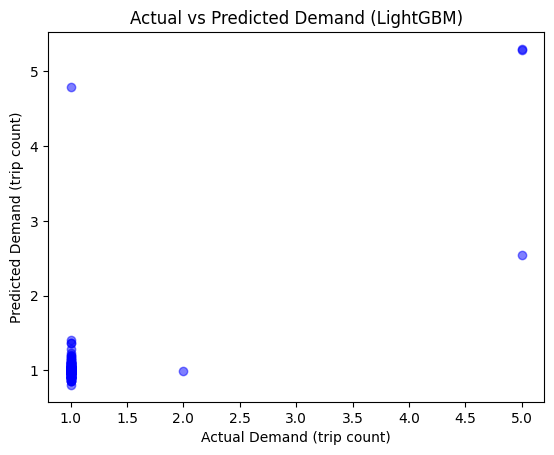

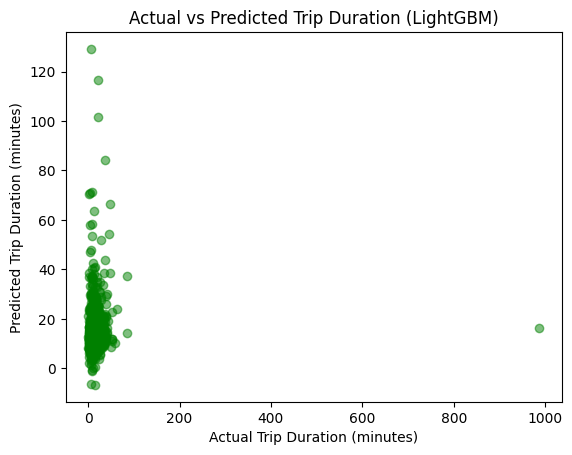

In [ ]:
# Step 6: Plot Results
# Demand
plt.scatter(y_test_demand, y_pred_demand, alpha=0.5, color='blue')
plt.xlabel("Actual Demand (trip count)")
plt.ylabel("Predicted Demand (trip count)")
plt.title("Actual vs Predicted Demand (LightGBM)")
plt.show()

# Duration
plt.scatter(y_test_duration, y_pred_duration, alpha=0.5, color='green')
plt.xlabel("Actual Trip Duration (minutes)")
plt.ylabel("Predicted Trip Duration (minutes)")
plt.title("Actual vs Predicted Trip Duration (LightGBM)")
plt.show()


In [ ]:
import joblib
from google.cloud import storage

# Save the trained models
joblib.dump(lgb_regressor_demand, 'lgb_regressor_demand.pkl')
joblib.dump(lgb_regressor_duration, 'lgb_regressor_duration.pkl')

# Upload models to GCS
bucket_name = "nycab-bucket"
client = storage.Client()

# Upload demand model
bucket = client.get_bucket(bucket_name)
demand_blob = bucket.blob('models/lgb_regressor_demand.pkl')
demand_blob.upload_from_filename('lgb_regressor_demand.pkl')

# Upload duration model
duration_blob = bucket.blob('models/lgb_regressor_duration.pkl')
duration_blob.upload_from_filename('lgb_regressor_duration.pkl')

print("Models uploaded to GCS successfully.")
